## Initialize

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

num_cpus = 15

import pandas as pd
#from distributed import Client
#client = Client()

import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import random
import pickle 

from pylift import TransformedOutcome
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# load data from BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery_storage

from utils import clean_circ, auc_gain, balance_deciles, circ_dtypes, now_EST, summarize_rates, jitter, vals
from utils import calc_MPNM, calc_cgains, collate_results


plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.size':10})

key_path = '/home/jupyter/nb4_d01_key.json'
key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])

#project=credentials.project_id
project = 'dw-bq-data-d00'
bq_client = bigquery.Client(project=project, credentials=credentials)
bqs_client = bigquery_storage.BigQueryReadClient(credentials=credentials)
project

'dw-bq-data-d00'

## Import from BQ and clean/prep data

In [2]:
%%time
print(now_EST(), 'begin load from BQ')
sql = """
select * 
from `dw-bq-data-d00.SANDBOX_ANALYTICS.Uplift_scoring`
order by ADDRESS_ID
"""

df_raw = bq_client.query(sql).to_dataframe(bqstorage_client=bqs_client)

18:30:43 begin load from BQ
CPU times: user 7min 21s, sys: 3min 58s, total: 11min 19s
Wall time: 6min 18s


In [3]:
# check no unknown columns 
set(df_raw.columns) - set(circ_dtypes) 

set()

In [4]:
df_raw.drop(['CONCEPT_FORMAT_ID','L12M_BBB_DYS_SINCE_CIRC_RDM','LY_COUP_TXNS','LY_NET_MARG','scoring_year_and_period'], axis=1, inplace=True, errors='ignore')

In [5]:
print(df_raw.shape)
df_raw.columns

(53389025, 37)


Index(['address_id', 'L12M_TOT_SALES', 'L12M_TOT_TXNS', 'L12M_BBB_CIRC',
       'L12M_BBB_KHC', 'L12M_BBB_TXNS', 'PH_CREDEEM365D', 'PH_CIRC_RECENCY',
       'PH_PREDEEM365D', 'PH_DM_RECENCY', 'PH_MREDEEM182D_PERC',
       'PH_MREDEEM730D_PERC', 'BBB_INSTORE_F', 'BBB_INSTORE_F_2Y', 'BBB_R_2Y',
       'BUYS_Q_01', 'BUYS_Q_02', 'BUYS_Q_03', 'BUYS_Q_04', 'BUYS_Q_05_08',
       'COUPON_TOT_PRC_RED', 'COUPON_Q_01', 'COUPON_Q_02', 'COUPON_Q_03',
       'COUPON_Q_04', 'COUPON_Q_05_08', 'COUPON_SALES_Q_05',
       'COUPON_SALES_Q_08', 'LY_PURCH_PERIODS', 'LY_PURCH_ITEMS',
       'LY_SLS_TXNS', 'LY_DAYS_SINCE_PURCH', 'A_A8588N_HM_SQR_FT',
       'AGE_APPROX', 'A_A9509N_EDU_1ST', 'GENDER', 'STORE_DISTANCE'],
      dtype='object')

In [6]:
%%time
print(now_EST())
df_cln = clean_circ(df_raw.copy())

18:38:33
18:38:50 filling NaNs with 0
18:39:13 filling NaNs
18:41:33 filling gender U
18:41:39 dropping U, X, COUPON_BARCODE1,L12M_BBB_USED_EXP_COUP
18:42:02 changing dtypes
18:45:17 further downcast dtypes if possible
CPU times: user 7min 11s, sys: 1min, total: 8min 11s
Wall time: 8min 10s


In [7]:
print(df_cln.shape)
df_cln.head()

(53389025, 37)


,address_id,L12M_TOT_SALES,L12M_TOT_TXNS,L12M_BBB_CIRC,L12M_BBB_KHC,L12M_BBB_TXNS,PH_CREDEEM365D,PH_CIRC_RECENCY,PH_PREDEEM365D,PH_DM_RECENCY,...,COUPON_SALES_Q_08,LY_PURCH_PERIODS,LY_PURCH_ITEMS,LY_SLS_TXNS,LY_DAYS_SINCE_PURCH,A_A8588N_HM_SQR_FT,AGE_APPROX,A_A9509N_EDU_1ST,GENDER,STORE_DISTANCE
0,3000000000003,NaN,<NA>,0,0,<NA>,0,2,0,30,...,0.0,4,9,6,205,0,30,1,F,2
1,3000000000004,NaN,<NA>,0,0,<NA>,0,58,0,1241,...,NaN,1,1,1,345,2276,<NA>,<NA>,F,10
2,3000000000005,NaN,0,0,0,<NA>,0,219,0,100,...,NaN,1,1,1,349,3672,30,1,F,3
3,3000000000006,NaN,<NA>,0,0,<NA>,0,1500,0,1479,...,NaN,1,4,1,357,<NA>,<NA>,<NA>,NaN,6
4,3000000000007,NaN,<NA>,0,0,<NA>,0,72,0,170,...,NaN,1,1,1,340,2385,<NA>,1,F,2


Don't use grp, OFFER_DESCRIPTION because these are correlated with Treatment  
Don't use visits, sales, net_sales, coupon_expense, margin because these are results derived after Treatment applied.


## Create features

In [8]:
df_cln['L12M_CIRC_per_TXN'] = df_cln.L12M_BBB_CIRC / df_cln.L12M_BBB_TXNS

## Best feature lists

In [18]:
cols_CIRC5a = ['A_A8588N_HM_SQR_FT', 'A_A9509N_EDU_1ST', 'AGE_APPROX', 'BBB_INSTORE_F', 'BBB_INSTORE_F_2Y', 'BBB_R_2Y', 
              'BUYS_Q_01', 'BUYS_Q_02', 'BUYS_Q_03', 'BUYS_Q_04', 'BUYS_Q_05_08', 
              'COUPON_TOT_PRC_RED', 'COUPON_Q_01', 'COUPON_Q_02', 'COUPON_Q_03', 'COUPON_Q_04', 'COUPON_Q_05_08', 
              'COUPON_SALES_Q_05', 'COUPON_SALES_Q_08', 'GENDER', 'LY_PURCH_PERIODS', 'LY_PURCH_ITEMS',  'LY_SLS_TXNS', 
              'PH_CIRC_RECENCY', 'PH_CREDEEM365D', 'PH_MREDEEM182D_PERC', 'PH_MREDEEM730D_PERC', 'LY_DAYS_SINCE_PURCH', 
              'STORE_DISTANCE', 'L12M_TOT_SALES', 'L12M_TOT_TXNS','L12M_BBB_CIRC','L12M_BBB_TXNS','L12M_CIRC_per_TXN']
cols_PC5a = ['A_A8588N_HM_SQR_FT', 'A_A9509N_EDU_1ST', 'AGE_APPROX', 'BBB_INSTORE_F', 'BBB_INSTORE_F_2Y', 'BBB_R_2Y', 
             'BUYS_Q_01', 'BUYS_Q_02', 'BUYS_Q_03', 'BUYS_Q_04', 'BUYS_Q_05_08', 
             'COUPON_TOT_PRC_RED', 'COUPON_Q_01', 'COUPON_Q_02', 'COUPON_Q_03', 'COUPON_Q_04', 'COUPON_Q_05_08', 
             'COUPON_SALES_Q_05', 'COUPON_SALES_Q_08', 'GENDER', 'LY_PURCH_PERIODS', 'LY_PURCH_ITEMS',  'LY_SLS_TXNS', 
             'PH_DM_RECENCY', 'PH_PREDEEM365D', 'PH_MREDEEM182D_PERC', 'PH_MREDEEM730D_PERC', 'LY_DAYS_SINCE_PURCH', 
             'STORE_DISTANCE', 'L12M_TOT_SALES', 'L12M_TOT_TXNS','L12M_BBB_KHC','L12M_BBB_TXNS','L12M_CIRC_per_TXN']
cols_ItemPC5a = cols_PC5a

#cols = cols_CIRC3 + ['Treated', 'shopped','CAMPAIGN_ID', 'GENDER'] 
#temp.index

In [21]:
set(cols_PC5a) - set(cols_ItemPC5a)

set()

## <font color="#668b8b">Predict using Saved model </font>

#### specify model and features

In [69]:
#cols = cols_ItemPC5a
#mod = 'mod_prod_ItemPC5a.json'
type = 'ItemPC'

cols = cols_PC5a
#mod = 'mod_full_PC5a_rs6.json'
type = 'ItemPC'
model_path = 'gs://datascience-modelartifacts/dm-uplift/itempc'

In [51]:
from google.cloud import storage

In [65]:
gcs_client = storage.Client()

with open("bins.pkl", 'wb') as bins, open("model.json", 'wb') as mod:
    gcs_client.download_blob_to_file(f"{model_path}/bins.pkl", bins)
    gcs_client.download_blob_to_file(f"{model_path}/model.json", mod)

with open('bins.pkl', 'rb') as f:
    bins = pickle.load(f)
bins

[-inf,
 0.00133,
 0.00169,
 0.00189,
 0.00217,
 0.00258,
 0.00292,
 0.00337,
 0.00395,
 0.00514,
 inf]

In [11]:
df2 = df_cln.copy()[cols]

In [12]:
dummies = [f for f in df2.columns if df2[f].dtype=='category']
print(dummies)
if len(dummies)>0:
    df2 = pd.get_dummies(df2, columns=dummies, drop_first=False)

df2.shape

['GENDER']


(53389025, 36)

In [67]:
from xgboost import XGBRegressor

sel_estimator = XGBRegressor()

sel_estimator.load_model('model.json')

In [ ]:
 sel_estimator.get_params(sel_estimator)

In [18]:
# if using older CIRC5a model with old feature names
# df2.rename(columns={'COUPON_TOT_PRC_RED': 'COUPON_ANY_AMT',
#                     'L12M_BBB_CIRC': 'BBB_CIRC_12M',
#                     'L12M_BBB_TXNS': 'BBB_TRANS_12M',
#                     'L12M_CIRC_per_TXN': 'CIRC_per_TRANS',
#                     'L12M_TOT_SALES': 'TOTAL_SALES_L12M',
#                     'L12M_TOT_TXNS': 'TOTAL_TXNS_L12M',
#                     'LY_DAYS_SINCE_PURCH': 'RECENCY',
#                     'LY_PURCH_ITEMS': 'NUM_TOTAL_ITEMS', 
#                     'LY_PURCH_PERIODS': 'NUM_PERIODS',
#                     'LY_SLS_TXNS': 'NUM_TXNS'}, inplace=True)

In [70]:
# check df2 and model features match
print(set(df2.columns) - set(sel_estimator.feature_names_in_))
set(sel_estimator.feature_names_in_) - set(df2.columns) 

set()


set()

In [71]:
%%time
preds = sel_estimator.predict(df2)

CPU times: user 3min 31s, sys: 7.69 s, total: 3min 39s
Wall time: 26.2 s


#### merge preds with data

In [73]:
# CIRC
#bins = [-np.inf, 0.001442, 0.002027, 0.002460, 0.002878, 0.003297, 0.003757, 0.004315, 0.005060, 0.006368, np.inf]
# Item PC based on 6 x 85/15 splits
#bins = [-np.inf, 0.00136133, 0.00167333, 0.00188067, 0.00213067, 0.002534, 0.00286867, 0.00341717, 0.00405983, 0.00537133, np.inf]
# Item PC based on train 100% of 22m recs
#bins = [-np.inf, 0.00133,    0.00169,    0.00189,    0.00217,    0.00258,  0.00292,    0.00337,    0.00395,    0.00514,    np.inf]
labels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
df_cln['score_U'] = preds
df_cln['decile_U'] = pd.cut(preds, bins=bins, labels=labels)

df_cln.head()

,address_id,L12M_TOT_SALES,L12M_TOT_TXNS,L12M_BBB_CIRC,L12M_BBB_KHC,L12M_BBB_TXNS,PH_CREDEEM365D,PH_CIRC_RECENCY,PH_PREDEEM365D,PH_DM_RECENCY,...,LY_SLS_TXNS,LY_DAYS_SINCE_PURCH,A_A8588N_HM_SQR_FT,AGE_APPROX,A_A9509N_EDU_1ST,GENDER,STORE_DISTANCE,L12M_CIRC_per_TXN,score_U,decile_U
0,3000000000003,NaN,<NA>,0,0,<NA>,0,2,0,30,...,6,205,0,30,1,F,2,<NA>,0.002334,6
1,3000000000004,NaN,<NA>,0,0,<NA>,0,58,0,1241,...,1,345,2276,<NA>,<NA>,F,10,<NA>,0.002045,7
2,3000000000005,NaN,0,0,0,<NA>,0,219,0,100,...,1,349,3672,30,1,F,3,<NA>,0.001861,8
3,3000000000006,NaN,<NA>,0,0,<NA>,0,1500,0,1479,...,1,357,<NA>,<NA>,<NA>,NaN,6,<NA>,0.002045,7
4,3000000000007,NaN,<NA>,0,0,<NA>,0,72,0,170,...,1,340,2385,<NA>,1,F,2,<NA>,0.002045,7


In [74]:
df_cln.groupby('decile_U').agg(n=('address_id','count')).sort_values('decile_U', ascending=False)

,n
decile_U,
1,967250
2,1790805
3,2091478
4,1349680
5,2171124
6,9551669
7,14553602
8,10612335
9,268204


## Export scores to gs csv

In [75]:
temp = df_cln.loc[:,['address_id','score_U','decile_U']]
temp.columns=['address_id','uplift_score','uplift_decile']

temp['concept_format_id'] = 1
temp['fiscal_period_id'] = 202301
temp['uplift_type'] = type
#temp = temp['concept_format_id','fiscal_period_id']
temp[temp.uplift_decile>=2]

,address_id,uplift_score,uplift_decile,concept_format_id,fiscal_period_id,uplift_type
47,3000000000124,0.004217,2,1,202301,ItemPC
49,3000000000129,0.004163,2,1,202301,ItemPC
60,3000000000163,0.004062,2,1,202301,ItemPC
66,3000000000175,0.004241,2,1,202301,ItemPC
124,3000000000344,0.005216,1,1,202301,ItemPC
...,...,...,...,...,...,...
53388552,3000461505954,0.004899,2,1,202301,ItemPC
53388584,3000461528990,0.004495,2,1,202301,ItemPC
53388654,3000461918405,0.004596,2,1,202301,ItemPC
53388756,3000462238572,0.012602,1,1,202301,ItemPC


In [76]:
%%time

seq = ['concept_format_id','fiscal_period_id','address_id','uplift_score','uplift_decile','uplift_type']
temp[seq].to_gbq(
        destination_table='SANDBOX_ANALYTICS.predicted_uplift_all',
        project_id=project,
        if_exists="replace",
        credentials=credentials
        )

100%|██████████| 1/1 [00:00<00:00, 6034.97it/s]

CPU times: user 11.6 s, sys: 3.1 s, total: 14.7 s
Wall time: 1min 14s


## CIRC pred vs Item DM actual 

#### pull in top 2.5M propensity

In [54]:
%%time
print(now_EST(), 'begin load from BQ')
sql = """
select
  decile, A.probability, A.address_guid as address_id
from  `dw-bq-data-p00.ANALYTICAL.main_event_circular_scored_history` A
where
  scoring_year_and_period=202211
--group by 1
order by 2 DESC

limit 2500000
"""

df_prop = bq_client.query(sql).to_dataframe(bqstorage_client=bqs_client)


22:59:54 begin load from BQ
CPU times: user 5.37 s, sys: 1.69 s, total: 7.05 s
Wall time: 7.85 s


In [57]:
df_prop.rename(columns={'decile':'decile_P'}, inplace=True)
df_prop.head()

,decile_P,probability,address_id
0,1.000000000,1.000000000,3000110823638
1,1.000000000,1.000000000,3000138254885
2,1.000000000,1.000000000,3000000165042
3,1.000000000,1.000000000,3000132386002
4,1.000000000,1.000000000,3000033946765


In [58]:
%%time
df_comp = df_cln[['address_id','score_U','decile_U']].copy()
df_comp = df_comp.merge(df_prop, on='address_id', how='outer')
df_comp

CPU times: user 1min 14s, sys: 10.2 s, total: 1min 25s
Wall time: 1min 25s


,address_id,score_U,decile_U,decile_P,probability
0,3000000000003,0.001574,9,NaN,NaN
1,3000000000004,0.001514,9,NaN,NaN
2,3000000000005,0.001385,9,NaN,NaN
3,3000000000006,0.001514,9,NaN,NaN
4,3000000000007,0.001514,9,NaN,NaN
...,...,...,...,...,...
53389020,3000462701959,0.000305,10,NaN,NaN
53389021,3000462791623,0.000305,10,NaN,NaN
53389022,3000462792068,0.000305,10,NaN,NaN
53389023,3000462792190,0.000305,10,NaN,NaN


#### Mark population of U as top 2.5M

In [60]:
%%time
df_comp['U_rank'] = df_comp.score_U.rank(ascending=False, method='first')
df_comp['U'] = 0
df_comp.loc[df_comp.U_rank<=2500000,'U'] = 1
df_comp

CPU times: user 10.4 s, sys: 641 ms, total: 11 s
Wall time: 11 s


,address_id,score_U,decile_U,decile_P,probability,U_rank,U
0,3000000000003,0.001574,9,NaN,NaN,18111278.0,0
1,3000000000004,0.001514,9,NaN,NaN,20496998.0,0
2,3000000000005,0.001385,9,NaN,NaN,28446980.0,0
3,3000000000006,0.001514,9,NaN,NaN,20496999.0,0
4,3000000000007,0.001514,9,NaN,NaN,20497000.0,0
...,...,...,...,...,...,...,...
53389020,3000462701959,0.000305,10,NaN,NaN,49005751.0,0
53389021,3000462791623,0.000305,10,NaN,NaN,49005752.0,0
53389022,3000462792068,0.000305,10,NaN,NaN,49005753.0,0
53389023,3000462792190,0.000305,10,NaN,NaN,49005754.0,0


#### sample from U

In [61]:
#df_comp.drop('US', axis=1, errors='ignore', inplace=True)
df = df_comp[df_comp.U==1].sample(840000+168000, random_state=1)
df['US'] = 1 
df_comp = df_comp.join(df.US)

#### drop rows that are neither P nor U

In [62]:
df_comp = df_comp.loc[(df_comp.U==1) | (df_comp.decile_P>0)]
df_comp.US.fillna(0, inplace=True)
df_comp = df_comp.astype({'U_rank':'int32','US':'uint8'})
df_comp

,address_id,score_U,decile_U,decile_P,probability,U_rank,U,US
49,3000000000129,0.003708,3,2.000000000,0.153719665,1767880,1,1
60,3000000000163,0.001232,10,2.000000000,0.162982793,42830969,0,0
66,3000000000175,0.003409,4,2.000000000,0.133387020,2349660,1,0
68,3000000000179,-0.003150,10,1.000000000,0.286573576,52880183,0,0
70,3000000000196,0.002665,5,2.000000000,0.175343504,4253392,0,0
...,...,...,...,...,...,...,...,...
53388584,3000461528990,0.003767,3,NaN,NaN,1709934,1,0
53388586,3000461536699,0.001303,10,2.000000000,0.141393068,39153479,0,0
53388593,3000461625050,0.003654,3,NaN,NaN,1911639,1,0
53388654,3000461918405,0.003586,3,1.000000000,0.297180323,1984717,1,0


#### sample from P

In [63]:
df = df_comp[df_comp.probability>0].sample(2*275000, random_state=1)
df['PS'] = 1 
df_comp = df_comp.join(df.PS)

df_comp.PS.fillna(0, inplace=True)
df_comp = df_comp.astype({'PS':'uint8'})
df_comp

,address_id,score_U,decile_U,decile_P,probability,U_rank,U,US,PS
49,3000000000129,0.003708,3,2.000000000,0.153719665,1767880,1,1,0
60,3000000000163,0.001232,10,2.000000000,0.162982793,42830969,0,0,0
66,3000000000175,0.003409,4,2.000000000,0.133387020,2349660,1,0,0
68,3000000000179,-0.003150,10,1.000000000,0.286573576,52880183,0,0,0
70,3000000000196,0.002665,5,2.000000000,0.175343504,4253392,0,0,0
...,...,...,...,...,...,...,...,...,...
53388584,3000461528990,0.003767,3,NaN,NaN,1709934,1,0,0
53388586,3000461536699,0.001303,10,2.000000000,0.141393068,39153479,0,0,0
53388593,3000461625050,0.003654,3,NaN,NaN,1911639,1,0,0
53388654,3000461918405,0.003586,3,1.000000000,0.297180323,1984717,1,0,1


#### sub-sample each for T and C

In [65]:
#df_comp.drop(['UST','PST'], axis=1, errors='ignore', inplace=True)
df = df_comp[df_comp.US==1].sample(n=840000, random_state=1)
df['UST'] = 1 
df_comp = df_comp.join(df.UST)
df_comp.UST.fillna(0, inplace=True)

df = df_comp[df_comp.PS==1].sample(frac=0.5, random_state=1)
df['PST'] = 1 
df_comp = df_comp.join(df.PST)
df_comp.PST.fillna(0, inplace=True)

df_comp = df_comp.astype({'PST':'uint8', 'UST':'uint8'})
df_comp

,address_id,score_U,decile_U,decile_P,probability,U_rank,U,US,PS,UST,PST
49,3000000000129,0.003708,3,2.000000000,0.153719665,1767880,1,1,0,1,0
60,3000000000163,0.001232,10,2.000000000,0.162982793,42830969,0,0,0,0,0
66,3000000000175,0.003409,4,2.000000000,0.133387020,2349660,1,0,0,0,0
68,3000000000179,-0.003150,10,1.000000000,0.286573576,52880183,0,0,0,0,0
70,3000000000196,0.002665,5,2.000000000,0.175343504,4253392,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
53388584,3000461528990,0.003767,3,NaN,NaN,1709934,1,0,0,0,0
53388586,3000461536699,0.001303,10,2.000000000,0.141393068,39153479,0,0,0,0,0
53388593,3000461625050,0.003654,3,NaN,NaN,1911639,1,0,0,0,0
53388654,3000461918405,0.003586,3,1.000000000,0.297180323,1984717,1,0,1,0,1


### Check sample results

In [66]:
pd.crosstab(df_comp.U, df_comp.US)

US,0,1
U,,
0,994561,0
1,1492000,1008000


In [67]:
pd.crosstab(df_comp.US, df_comp.UST)

UST,0,1
US,,
0,2486561,0
1,168000,840000


In [68]:
pd.crosstab(df_comp.decile_P, df_comp.PS).sum()

PS
0    1950000
1     550000
dtype: int64

In [69]:
pd.crosstab(df_comp.PS, df_comp.PST)

PST,0,1
PS,,
0,2944561,0
1,275000,275000


In [70]:
pd.crosstab(df_comp.UST, df_comp.PST)

PST,0,1
UST,,
0,2435122,219439
1,784439,55561


In [71]:
df_comp['USH'] = 0
df_comp['PSH'] = 0
df_comp.loc[(df_comp.US==1) & (df_comp.UST==0), 'USH'] = 1
df_comp.loc[(df_comp.PS==1) & (df_comp.PST==0), 'PSH'] = 1
pd.crosstab(df_comp.USH, df_comp.PSH)

PSH,0,1
USH,,
0,3062511,264050
1,157050,10950


## Alternative

In [133]:
df = df_comp[df_comp.U==1].sample(840000, random_state=1)
df['UT'] = 1 
df_comp = df_comp.join(df.UT)
df_comp.UT.fillna(0, inplace=True)
df_comp

,address_id,score,decile_U,decile_P,probability,U_rank,U,PS,US,UST,PST,USH,PSH,UT
49,3000000000129,0.006733,1,2.000000000,0.153719665,1748784,1,0,1,1,0,0,0,1.0
60,3000000000163,0.005646,2,2.000000000,0.162982793,3089802,0,0,0,0,0,0,0,0.0
66,3000000000175,0.006853,1,2.000000000,0.133387020,1644604,1,0,0,0,0,0,0,0.0
68,3000000000179,0.025227,1,1.000000000,0.286573576,25999,1,0,1,1,0,0,0,1.0
70,3000000000196,0.007154,1,2.000000000,0.175343504,1423227,1,0,1,1,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53388654,3000461918405,0.005843,2,1.000000000,0.297180323,2795596,0,1,0,0,1,0,0,0.0
53388708,3000462038306,0.006743,1,NaN,NaN,1741225,1,0,0,0,0,0,0,0.0
53388756,3000462238572,0.032414,1,NaN,NaN,15314,1,0,0,0,0,0,0,0.0
53388822,3000462327596,0.007108,1,NaN,NaN,1453154,1,0,0,0,0,0,0,0.0


In [134]:
df = df_comp.loc[(df_comp.U==1) & (df_comp.UT==0)].sample(168000, random_state=1)
df['UH'] = 1 
df_comp = df_comp.join(df.UH)
df_comp.UH.fillna(0, inplace=True)

In [138]:
df_comp.sample(15)

,address_id,score,decile_U,decile_P,probability,U_rank,U,PS,US,UST,PST,USH,PSH,UT,UH
5226378,3000014642669,0.003023,6,3.000000000,0.122711482,10385897,0,0,0,0,0,0,0,0.0,0.0
37230319,3000111755589,0.008201,1,NaN,NaN,874774,1,0,1,1,0,0,0,1.0,0.0
48229027,3000154484301,0.008471,1,2.000000000,0.145096951,769794,1,1,0,0,1,0,0,0.0,0.0
3470986,3000009696340,0.006923,1,1.000000000,0.192467309,1593196,1,0,1,1,0,0,0,1.0,0.0
32676353,3000096704671,0.005553,2,2.000000000,0.169263773,3234981,0,0,0,0,0,0,0,0.0,0.0
9691911,3000027361158,0.006949,1,2.000000000,0.159798529,1571877,1,0,0,0,0,0,0,0.0,0.0
28395174,3000083105741,-0.001816,10,1.000000000,0.348820443,53356824,0,1,0,0,0,0,1,0.0,0.0
14565056,3000041470335,0.016972,1,2.000000000,0.154914114,59365,1,1,1,1,1,0,0,1.0,0.0
50736882,3000222186638,0.004651,3,3.000000000,0.121238910,5071318,0,0,0,0,0,0,0,0.0,0.0
19387929,3000055679251,0.006705,1,NaN,NaN,1776868,1,0,1,0,0,1,0,1.0,0.0


In [139]:
df = df_comp[df_comp.probability>0].sample(275000, random_state=1)
df['PT'] = 1 
df_comp = df_comp.join(df.PT)
df_comp.PT.fillna(0, inplace=True)
df_comp

,address_id,score,decile_U,decile_P,probability,U_rank,U,PS,US,UST,PST,USH,PSH,UT,UH,PT
49,3000000000129,0.006733,1,2.000000000,0.153719665,1748784,1,0,1,1,0,0,0,1.0,0.0,0.0
60,3000000000163,0.005646,2,2.000000000,0.162982793,3089802,0,0,0,0,0,0,0,0.0,0.0,0.0
66,3000000000175,0.006853,1,2.000000000,0.133387020,1644604,1,0,0,0,0,0,0,0.0,0.0,0.0
68,3000000000179,0.025227,1,1.000000000,0.286573576,25999,1,0,1,1,0,0,0,1.0,0.0,0.0
70,3000000000196,0.007154,1,2.000000000,0.175343504,1423227,1,0,1,1,0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53388654,3000461918405,0.005843,2,1.000000000,0.297180323,2795596,0,1,0,0,1,0,0,0.0,0.0,0.0
53388708,3000462038306,0.006743,1,NaN,NaN,1741225,1,0,0,0,0,0,0,0.0,0.0,0.0
53388756,3000462238572,0.032414,1,NaN,NaN,15314,1,0,0,0,0,0,0,0.0,0.0,0.0
53388822,3000462327596,0.007108,1,NaN,NaN,1453154,1,0,0,0,0,0,0,0.0,0.0,0.0


In [140]:
df = df_comp.loc[(df_comp.probability>0) & (df_comp.PT==0)].sample(275000, random_state=1)
df['PH'] = 1 
df_comp = df_comp.join(df.PH)
df_comp.PH.fillna(0, inplace=True)

In [146]:
df_comp.sample(15)

,address_id,score,decile_U,decile_P,probability,U_rank,U,PS,US,UST,PST,USH,PSH,UT,UH,PT,PH
51304475,3000304941457,0.006564,1,NaN,NaN,1906347,1,0,1,1,0,0,0,1.0,0.0,0.0,0.0
10838037,3000030656729,0.008059,1,1.000000000,0.209603162,935630,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
18305325,3000052467064,0.029114,1,1.000000000,0.902950623,19248,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
26320649,3000076665400,0.007755,1,NaN,NaN,1082011,1,0,1,1,0,0,0,1.0,0.0,0.0,0.0
26604631,3000077542676,0.004859,3,2.000000000,0.136045780,4570860,0,1,0,0,0,0,1,0.0,0.0,1.0,0.0
22525264,3000065082243,0.008938,1,NaN,NaN,618567,1,0,1,1,0,0,0,0.0,0.0,0.0,0.0
42294848,3000129632437,0.007148,1,NaN,NaN,1426248,1,0,1,1,0,0,0,1.0,0.0,0.0,0.0
18654024,3000053500145,0.003927,4,2.000000000,0.129075302,6809094,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1616302,3000004495795,0.005875,2,2.000000000,0.157734562,2746658,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0
41289561,3000125945891,0.010507,1,2.000000000,0.135791542,301180,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0


### Check sample results

In [148]:
pd.crosstab(df_comp.U, df_comp.UT)

UT,0.0,1.0
U,,
0,1004320,0
1,1660000,840000


In [149]:
pd.crosstab(df_comp.UT, df_comp.UH)

UH,0.0,1.0
UT,,
0.0,2496320,168000
1.0,840000,0


In [151]:
pd.crosstab(df_comp.decile_P, df_comp.PT).sum()

PT
0.0    2225000
1.0     275000
dtype: int64

In [152]:
pd.crosstab(df_comp.PT, df_comp.PH)

PH,0.0,1.0
PT,,
0.0,2954320,275000
1.0,275000,0


In [153]:
pd.crosstab(df_comp.UT, df_comp.PT)

PT,0.0,1.0
UT,,
0.0,2444585,219735
1.0,784735,55265


In [154]:
pd.crosstab(df_comp.UH, df_comp.PH)

PH,0.0,1.0
UH,,
0.0,3072310,264010
1.0,157010,10990


### Save/Load results

In [31]:
%time
# load if need be    
with open('res_shopped.pkl', 'rb') as f:
    res = pickle.load(f)

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 21.5 µs


In [ ]:
res

### Analyse Results

In [36]:
Title = 'Cumulative gains - Shopper (uplift)'
res_type = 'uplf'

temp = {}
rvals = sorted(list(res.keys()))
for r in rvals:
    temp[r] = res[r][res_type].
pd.DataFrame(temp)

,1,2,3,4,5,6
19,"(0.0077, 1.034]","(0.00754, 1.139]","(0.0079, 1.032]","(0.00788, 1.028]","(0.00796, 1.349]","(0.0079, 1.212]"
18,"(0.0063, 0.0077]","(0.00623, 0.00754]","(0.00632, 0.0079]","(0.00652, 0.00788]","(0.00648, 0.00796]","(0.00636, 0.0079]"
17,"(0.00554, 0.0063]","(0.00556, 0.00623]","(0.00553, 0.00632]","(0.00573, 0.00652]","(0.00568, 0.00648]","(0.00555, 0.00636]"
16,"(0.00502, 0.00554]","(0.00507, 0.00556]","(0.00497, 0.00553]","(0.0052, 0.00573]","(0.00512, 0.00568]","(0.00498, 0.00555]"
15,"(0.0046, 0.00502]","(0.0047, 0.00507]","(0.00457, 0.00497]","(0.00478, 0.0052]","(0.00468, 0.00512]","(0.00457, 0.00498]"
14,"(0.00424, 0.0046]","(0.00439, 0.0047]","(0.00426, 0.00457]","(0.00442, 0.00478]","(0.00434, 0.00468]","(0.00424, 0.00457]"
13,"(0.00395, 0.00424]","(0.0041, 0.00439]","(0.00399, 0.00426]","(0.00409, 0.00442]","(0.00406, 0.00434]","(0.00395, 0.00424]"
12,"(0.00371, 0.00395]","(0.00383, 0.0041]","(0.00375, 0.00399]","(0.00378, 0.00409]","(0.00377, 0.00406]","(0.0037, 0.00395]"
11,"(0.00348, 0.00371]","(0.00358, 0.00383]","(0.00352, 0.00375]","(0.00349, 0.00378]","(0.00352, 0.00377]","(0.00348, 0.0037]"
10,"(0.00328, 0.00348]","(0.00337, 0.00358]","(0.00331, 0.00352]","(0.00324, 0.00349]","(0.00331, 0.00352]","(0.00327, 0.00348]"


In [94]:
res[1]['uplf']

,pred,N,nT,nC,Ts_raw,Cs_raw,Ts_adj,Cs_adj,Tmargin,Cmargin,Tmarg_adj,Cmarg_adj,Tcu,Ccu,Tcu_adj,Ccu_adj,Tce,Cce,Tce_adj,Cce_adj
19,"(0.0077, 1.034]",423121,377691,45430,54963,6640,62072.040012,57444.537108,1.012596e+06,120363.968750,1.143981e+06,1.038335e+06,46241,5379,52240.018096,46290.131300,679069.312500,74050.273438,767738.180854,636229.846556
18,"(0.0063, 0.0077]",423120,381263,41857,36233,3944,40617.020882,36301.076904,7.217729e+05,83749.421875,8.090600e+05,7.656613e+05,29890,3183,33519.430081,29168.327091,450208.656250,49569.539062,505503.269426,445601.383032
17,"(0.00554, 0.0063]",423120,380733,42387,30960,3526,34701.192241,32660.518938,6.531749e+05,76021.273438,7.319231e+05,6.719007e+05,25233,2799,28292.372744,25745.747033,391591.531250,46812.660156,439748.616124,435825.179030
16,"(0.00502, 0.00554]",423121,381107,42014,26762,3048,29937.716969,28466.296602,5.938336e+05,69821.750000,6.636796e+05,6.554332e+05,21396,2402,23946.775972,22203.093576,348434.843750,39544.949219,390574.256061,362742.873436
15,"(0.0046, 0.00502]",423120,381325,41795,24703,2672,27614.221425,25121.446125,5.627369e+05,62910.839844,6.289334e+05,5.961904e+05,19360,2086,21654.256517,19457.648861,322491.718750,36047.300781,361495.022942,329556.316696
14,"(0.00424, 0.0046]",423120,381195,41925,23190,2523,25904.429562,23649.394312,5.247752e+05,60730.058594,5.854173e+05,5.758688e+05,17706,1880,19787.668036,17528.138030,299613.812500,35215.359375,335171.519478,325436.335720
13,"(0.00395, 0.00424]",423121,381729,41392,21970,2349,24516.647122,22723.309138,5.361488e+05,56076.648438,5.978339e+05,5.636113e+05,16484,1732,18403.667303,16597.381563,287530.187500,31151.480469,321650.052281,295362.876253
12,"(0.00371, 0.00395]",423120,381911,41209,20273,2235,22594.317631,21726.357843,5.011468e+05,54707.460938,5.573673e+05,5.399797e+05,15023,1580,16749.241895,15071.868490,266322.531250,27821.570312,297279.659000,266904.919669
11,"(0.00348, 0.00371]",423120,381527,41593,19513,2046,21767.421046,19778.135357,4.972999e+05,52344.980469,5.533789e+05,5.115070e+05,14246,1447,15901.279948,13875.361927,258968.562500,26085.710938,289432.210825,248851.580715
10,"(0.00328, 0.00348]",423120,381269,41851,18407,1931,20525.215719,18718.429380,4.732882e+05,54919.238281,5.266348e+05,5.436640e+05,13070,1330,14586.322716,12728.805420,240716.671875,25625.529297,268825.992637,240907.337539


#### Incremental MPNM

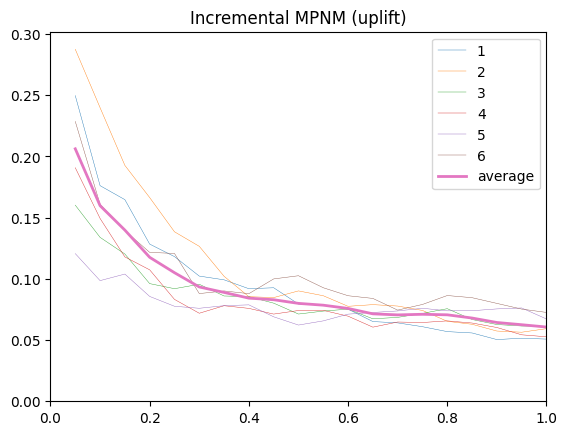

In [89]:
Title = 'Incremental MPNM (uplift)'
res_type = 'uplf'
colT='Tmarg_adj'
colC='Cmarg_adj'

temp = {}
rvals = sorted(list(res.keys()))
ymax = 0
for r in rvals:
    x, _, MPNM,  = calc_MPNM(res[r][res_type], colT=colT, colC=colC)
    plt.plot(x, MPNM, linewidth=0.3)
    temp[r] = MPNM
    if max(list(MPNM))>ymax:
        ymax = max(list(MPNM))
plt.title(Title)
plt.xlim([0,1])
plt.ylim([0,ymax*1.05])

uplf_MPNM_av = pd.DataFrame(temp).mean(axis=1)

plt.plot(x, uplf_MPNM_av, linewidth=2)
plt.legend(rvals+['average',])

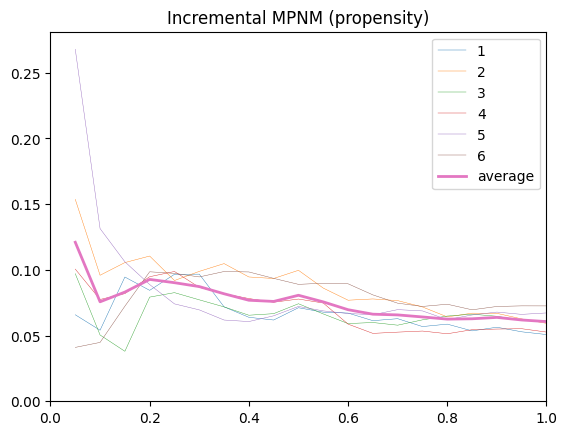

In [90]:
Title = 'Incremental MPNM (propensity)'
res_type = 'prop'
colT='Tmarg_adj'
colC='Cmarg_adj'

temp = {}
rvals = sorted(list(res.keys()))
ymax = 0
for r in rvals:
    x, _, MPNM,  = calc_MPNM(res[r][res_type], colT=colT, colC=colC)
    plt.plot(x, MPNM, linewidth=0.3)
    temp[r] = MPNM
    if max(list(MPNM))>ymax:
        ymax = max(list(MPNM))
plt.title(Title)
plt.xlim([0,1])
plt.ylim([0,ymax*1.05])

prop_MPNM_av = pd.DataFrame(temp).mean(axis=1)

plt.plot(x, prop_MPNM_av, linewidth=2)
plt.legend(rvals+['average',])

In [96]:
x2 = [int(i) for i in np.linspace(0,18,10)]
prop_MPNM_av = list(prop_MPNM_av)
y_prop = [np.mean([prop_MPNM_av[i],prop_MPNM_av[i+1]]) for i in x2]
uplf_MPNM_av = list(uplf_MPNM_av)
y_uplf = [np.mean([uplf_MPNM_av[i],uplf_MPNM_av[i+1]]) for i in x2]
x3 = np.array(x2)/20 + .1


In [99]:
y_uplf

[0.18300132995595295,
 0.12870912351360633,
 0.09920385282136243,
 0.08657818984882398,
 0.08145972909470899,
 0.07716172127716257,
 0.07099016026639968,
 0.07084155250818285,
 0.06617617223378933,
 0.061589092996325374]

Text(0, 0.5, 'MPNM')

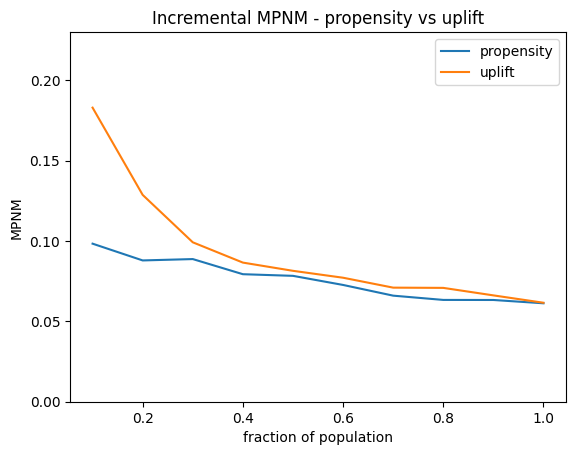

In [97]:
Title = 'Incremental MPNM - propensity vs uplift'

plt.plot(x3, y_prop)

plt.plot(x3, y_uplf)
plt.title(Title)

plt.legend(['propensity','uplift'])
plt.ylim([0,0.23])
plt.xlabel('fraction of population')
plt.ylabel('MPNM')

In [96]:
np.round(uplf_MPNM_av - prop_MPNM_av,3)

19    0.085
18    0.084
17    0.057
16    0.025
15    0.015
14    0.006
13    0.007
12    0.007
11    0.007
10   -0.001
9     0.003
8     0.006
7     0.005
6     0.005
5     0.007
4     0.008
3     0.005
2     0.001
1     0.001
0     0.000
dtype: float64

In [97]:
prop_MPNM_av

[0.12101858849524444,
 0.07569653152490327,
 0.0831061216794093,
 0.09273855937449339,
 0.09024813653167811,
 0.08728704754663404,
 0.08181863192060264,
 0.0768880413859888,
 0.07599068760101375,
 0.08067781333530803,
 0.07564153169425666,
 0.0696902899954851,
 0.06627961246805472,
 0.06573384225610245,
 0.06417250895773498,
 0.0625282102877054,
 0.06278415052101965,
 0.06383556782397111,
 0.06187044746053983,
 0.060643488428482446]